In [1]:
import warnings
warnings.filterwarnings("ignore")

# Chapter 3. Classification

In the MNIST data set, there are 70,000 images with 784 features ($28 \times 28$ pixels), where each pixel is in the range $[0, 255]$. 

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist ['data'], mnist ['target']
y.shape, X.shape

((70000,), (70000, 784))

Lets take a look at an image. We need to reshape an instance (a row in data), to a $28 \times 28$ array and display it by **Matlablib's imshow()**

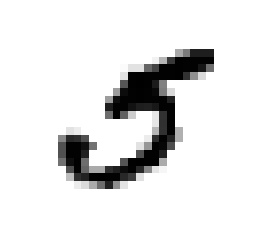

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X [36 * 1000]
some_digit_image = some_digit.reshape (28, 28)

plt.imshow (some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')

plt.axis ('off')
plt.show()

In [5]:
y [36 * 1000]

5.0

MNIST data has already split into a training set (the first 60,000 images) and a test test (the last 10,000 images).

In [6]:
X_train, X_test, y_train, y_test = X [:60 * 1000], X [60 * 1000:], y [:60 * 1000], y [60 * 1000:]

We need to shuffle our training set to make sure that cross-validation folds will yield similar results. Moreover, some ML algorithms perform poorly if they get similar instances in a row. It can be done simply with __numpy__

In [7]:
import numpy as np
shuffle_index = np.random.permutation(60 * 1000)
X_train, y_train = X_train [shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

Lets simplify the problem. Lets decise if the given image is $5$ or not $5$. 

In [8]:
y_train_5 = (y_train == 5) # y_train_5 will be True if for all 5s in y_train; otherwise, False
y_test_5 = (y_test == 5)

Lets pick a training model like **Stochastic Gradient Descent**, which is fast to deal with very large datasets.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier (random_state=42)
sgd_clf.fit (X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# Cross Validation Implementation

Let's evaluate our model more using **cross validation**. It is better to implement your own cross validation function to control what you are evaluating. **StratifiedKFold** performs stratified sampling that contain a representative ratio of each class. We are using clone to have a clone of the classifier in each iteration of the our function.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=4, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9647356842877142
0.8957333333333334
0.9551333333333333
0.927728515234349


Lets used the **built-in cross validation function** provided by **Scikit Learn**

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=4, scoring='accuracy')

array([0.96473568, 0.89573333, 0.95513333, 0.92772852])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # all the cells are zero!

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=4, scoring='accuracy')

array([0.90893333, 0.9098    , 0.90733333, 0.91253333])

It shows that the accuracy is always high! This is because around $%10$ of the images are $5s$. So, even use of cross validation here does not imply our classifier works well! especially when you are dealing with **skewed datasets**

# Confusion Matrix